# Unsupervised Machine Learning for Perovskite Thin-Film in-situ Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from sklearn.preprocessing import Normalizer

In [2]:
# read in data 
pathData = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/singleDF_Train.h5'
db = pd.read_hdf(pathData, 'df')

In [3]:
# define plotting parameters
pceLims = (5,17.5)
vocLims = (0.9,1.15)
jscLims = (16,22)
ffLims = (40,75)
fontSizeSetLarge = 18
fontSizeSetMedium = 14
fontSizeSetTitle = 26

In [4]:
# get data acquired through the LP725 filter
data = pd.DataFrame(data = np.vstack(db["LP725"].to_numpy()))
X = data.values.copy()

In [5]:
# generate a kmeans model with k = 4
k = 4
km = KMeans(n_clusters = k, random_state = 0)
cluster_found = km.fit_predict(X)
firstClustering = data.set_index(pd.Series(cluster_found, name = 'cluster'), append = True )
cluster_values = sorted(firstClustering.index.get_level_values('cluster').unique())

In [6]:
# generate 4 colors from the colormap viridis
ks = np.linspace(0.3,0.9,k)
color_list = []
cmap = plt.cm.get_cmap('viridis')
for zz in range(len(ks)):
    color_list.append(cmap(ks[zz]))

In [7]:
# generate a nested list with the PV parameters (pce,voc,jsc,ff) for the 4 generated clusters
listPCE,listVOC,listJSC,listFF = [],[],[],[]
for cluster, color in zip(cluster_values, color_list):
    clusterDF = firstClustering.xs(cluster, level = 1)
    listPCE.append(db.iloc[clusterDF.index]["pce_backward"])
    listVOC.append(db.iloc[clusterDF.index]["voc_backward"])
    listJSC.append(db.iloc[clusterDF.index]["jsc_backward"])
    listFF.append(db.iloc[clusterDF.index]["ff_backward"])
pvParamsClusters_unsorted = [listPCE,listVOC,listJSC,listFF]

In [8]:
# sort the nested list. the order of the clusters is changed so that the median pce of the cluster increases with cluster number
medianList = []
for x in range(len(listPCE)):
    medianList.append(np.median(listPCE[x]))
sortBy = sorted(range(len(medianList)), key = lambda k: medianList[k])
newClusters = []
for a in range(len(sortBy)):
    newClusters.append(sortBy.index(a))
cluster_found_sorted = pd.Series(np.array(newClusters)[np.array(firstClustering.index.get_level_values('cluster'))], name='cluster')
firstClustering = data.set_index(cluster_found_sorted, append = True )
clusters = sorted(firstClustering.index.get_level_values('cluster').unique())
listPCE_sorted = np.array(listPCE,dtype = object)[sortBy]
listVOC_sorted = np.array(listVOC,dtype = object)[sortBy]
listJSC_sorted = np.array(listJSC,dtype = object)[sortBy]
listFF_sorted = np.array(listFF,dtype = object)[sortBy]
pvParamsClusters = [listPCE_sorted,listVOC_sorted,listJSC_sorted,listFF_sorted]

# Figure 4

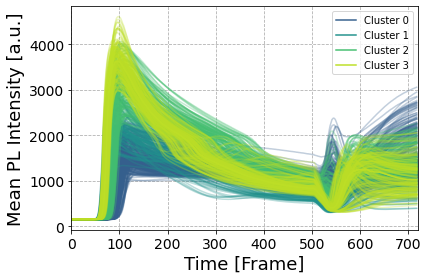

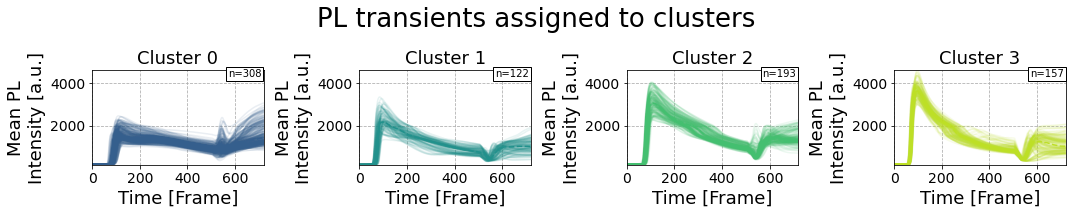

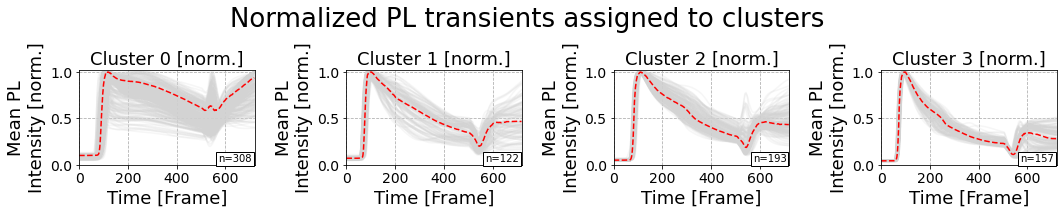

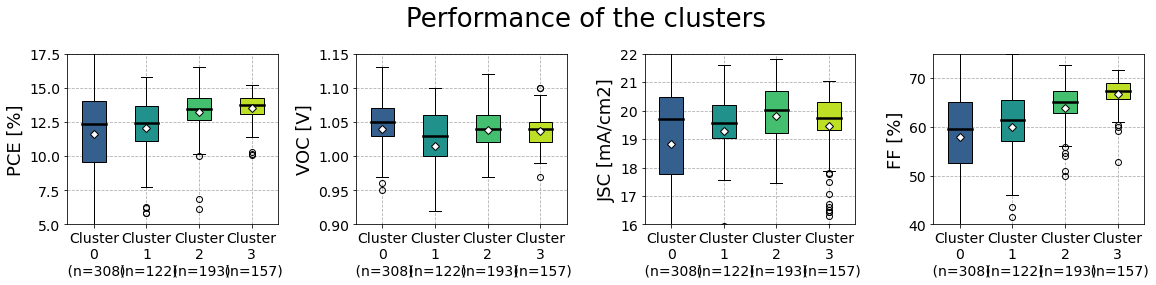

In [9]:
# plot all PL transient color-coded depending on the cluster they are assigned to
fig,ax = plt.subplots(1,1, figsize = (6,4))
for cluster, color in zip(cluster_values, color_list):
    clusterDF = firstClustering.xs(cluster, level = 1)
    for row in range(len(clusterDF)):
        ax.plot(clusterDF.iloc[row], alpha = 0.3, color=color)
    ax.plot(clusterDF.median(), alpha = 0.99, color=color, label = f'Cluster {cluster}') 
ax.legend(fontsize = 10)
ax.set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
ax.set_ylabel("Mean PL Intensity [a.u.]", fontsize = fontSizeSetLarge)
ax.grid(which = "both", linestyle = '--')
ax.tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
plt.xlim(0,720)
fig.tight_layout() 
plt.show()



# plot all PL transients assigned to the different clusters into different subplots
fig,ax = plt.subplots(1,k, figsize = (15,3))
for cluster, color in zip(cluster_values, color_list):
    clusterDF = firstClustering.xs(cluster, level = 1)
    for row in range(len(clusterDF)):
        ax[cluster].plot(clusterDF.iloc[row], color = color,alpha = 0.1)
    ax[cluster].set_ylim(np.min(np.asarray(firstClustering)),np.max(np.asarray(firstClustering)))
    ax[cluster].text(570,4300,"n="+str(len(clusterDF)), fontsize = 10, bbox = dict(facecolor = 'white', edgecolor = 'black', pad = 2.0))
    ax[cluster].set_title(f'Cluster {cluster}', fontsize = fontSizeSetLarge)
    ax[cluster].set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
    ax[cluster].set_ylabel("Mean PL\nIntensity [a.u.]", fontsize = fontSizeSetLarge)
    ax[cluster].plot(clusterDF.median(), alpha = 0.99, color = color, ls = '--')
    ax[cluster].grid(which = "both", linestyle = '--')
    ax[cluster].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
    ax[cluster].set_xlim(0,720)
plt.suptitle("PL transients assigned to clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()



# plot all normalized PL transients assigned to the different clusters into different subplots
fig,ax = plt.subplots(1,k, figsize = (15,3))
for cluster, color in zip(cluster_values, color_list):
    clusterDF = firstClustering.xs(cluster, level = 1)
    noOfcurves = 0
    for row in range(len(clusterDF)):
        currPlot = clusterDF.iloc[row]
        currPlot = np.divide(currPlot,np.max(currPlot))
        ax[cluster].plot(currPlot, "lightgray",alpha = 0.2)
        noOfcurves += 1
    ax[cluster].plot(np.divide(clusterDF.median(),np.max(clusterDF.median())), alpha = 0.99, color = "r", ls = '--', label = f'Cluster {cluster}' )
    ax[cluster].text(570,0.03,"n="+str(noOfcurves), fontsize = 10, bbox = dict(facecolor = 'white', edgecolor = 'black', pad = 2.0))
    ax[cluster].set_title(f'Cluster {cluster} [norm.]', fontsize = fontSizeSetLarge)
    ax[cluster].set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
    ax[cluster].set_ylabel("Mean PL\nIntensity [norm.]", fontsize = fontSizeSetLarge)
    ax[cluster].grid(which = "both", linestyle = '--')
    ax[cluster].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
    ax[cluster].set_xlim(0,720)
    ax[cluster].set_ylim(0,1.02)
plt.suptitle("Normalized PL transients assigned to clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()


# plot the performance parameters of the different clusters in the form of box plots
medianprops = dict(linestyle = '-', linewidth = 2.5, color = 'k')
meanprops = dict(marker = 'D', markeredgecolor = 'black',markerfacecolor = 'white')
xlabels = []
for x in range(len(clusters)):
    xlabels.append("Cluster\n" + str(clusters[x])) 
fig,ax = plt.subplots(1,4, figsize = (16,4))
for ix, paramName in enumerate(["pce","voc","jsc","ff"]):
    bplot1 = ax[ix].boxplot(pvParamsClusters[ix], medianprops = medianprops, meanprops = meanprops, meanline = False, showmeans = True,patch_artist = True) 
    cnt = 0
    for box in bplot1['boxes']:
        box.set(facecolor = color_list[cnt] ) 
        cnt += 1
    ax[ix].set_xticks(np.add(clusters,1), minor = False)
    nList = []
    for cluster, color in zip(clusters, color_list):
        nList.append("\n (n=" +str(len(pvParamsClusters[3][cluster]))+")")
    newList = []
    for yy in range(len(xlabels)):
        newList.append(xlabels[yy]+nList[yy])
    ax[ix].set_xticklabels(newList, fontdict = None, minor = False, fontsize = fontSizeSetLarge)
    ax[ix].grid(which = "both", linestyle = '--')
    ax[ix].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
ax[0].set_ylim(pceLims)
ax[1].set_ylim(vocLims)
ax[2].set_ylim(jscLims)
ax[3].set_ylim(ffLims)
ax[0].set_ylabel("PCE [%]", fontsize = fontSizeSetLarge) 
ax[1].set_ylabel("VOC [V]", fontsize = fontSizeSetLarge) 
ax[2].set_ylabel("JSC [mA/cm2]", fontsize = fontSizeSetLarge) 
ax[3].set_ylabel("FF [%]", fontsize = fontSizeSetLarge) 
plt.suptitle("Performance of the clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()

clustNo:  0


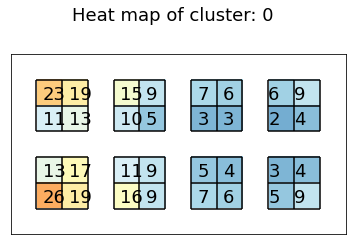

clustNo:  1


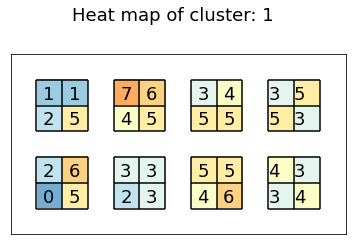

clustNo:  2


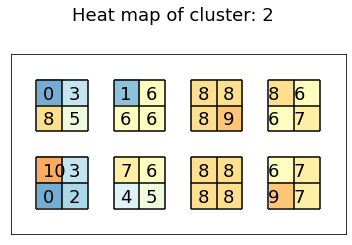

clustNo:  3


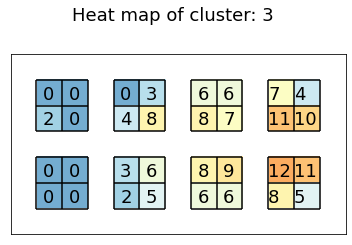

In [10]:
# iterate through all clusters and plot a map showing at which substrate locations the PL signals assigned to the cluster were detected
for clustNo in clusters:
    print("clustNo: ",clustNo)
    
    # in current cluster get number of cells located at each patchID (pacthID encodes the location of each solar cell on the large substrate)
    locID = {
          11: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==11]),
          12: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==12]),
          13: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==13]),
          14: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==14]),
          21: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==21]),
          22: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==22]),
          23: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==23]),
          24: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==24]),
          31: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==31]),
          32: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==32]),
          33: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==33]),
          34: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==34]),
          41: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==41]),
          42: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==42]),
          43: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==43]),
          44: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==44]),
          51: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==51]),
          52: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==52]),
          53: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==53]),
          54: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==54]),
          61: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==61]),
          62: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==62]),
          63: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==63]),
          64: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==64]),
          71: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==71]),
          72: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==72]),
          73: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==73]),
          74: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==74]),
          81: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==81]),
          82: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==82]),
          83: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==83]),
          84: len(db.iloc[firstClustering.xs(clustNo, level=1).index][db.iloc[firstClustering.xs(clustNo, level=1).index]["patchID"]==84])    }

    
    # arrange the solar cells assigned to the different patchIDs to the phyical location on the large substrate
    physicalLocations = np.zeros((4,8))
    physicalLocations[3,6] = locID[11]
    physicalLocations[2,6] = locID[12]
    physicalLocations[3,7] = locID[13]
    physicalLocations[2,7] = locID[14]
    physicalLocations[1,6] = locID[21]
    physicalLocations[0,6] = locID[22]
    physicalLocations[1,7] = locID[23]
    physicalLocations[0,7] = locID[24]
    physicalLocations[3,4] = locID[31]
    physicalLocations[2,4] = locID[32]
    physicalLocations[3,5] = locID[33]
    physicalLocations[2,5] = locID[34]
    physicalLocations[1,4] = locID[41]
    physicalLocations[0,4] = locID[42]
    physicalLocations[1,5] = locID[43]
    physicalLocations[0,5] = locID[44]
    physicalLocations[3,2] = locID[51]
    physicalLocations[2,2] = locID[52]
    physicalLocations[3,3] = locID[53]
    physicalLocations[2,3] = locID[54]
    physicalLocations[1,2] = locID[61]
    physicalLocations[0,2] = locID[62]
    physicalLocations[1,3] = locID[63]
    physicalLocations[0,3] = locID[64]
    physicalLocations[3,0] = locID[71]
    physicalLocations[2,0] = locID[72]
    physicalLocations[3,1] = locID[73]
    physicalLocations[2,1] = locID[74]
    physicalLocations[1,0] = locID[81]
    physicalLocations[0,0] = locID[82]
    physicalLocations[1,1] = locID[83]
    physicalLocations[0,1] = locID[84]

    # space the physical locations out on the area of the entire substrate 
    substrate = np.empty((7,13))
    substrate[:,:] = np.NaN
    substrate[1:3,1:3] = physicalLocations[0:2,0:2]
    substrate[4:6,1:3] = physicalLocations[2:4,0:2]
    substrate[1:3,4:6] = physicalLocations[0:2,2:4]
    substrate[4:6,4:6] = physicalLocations[2:4,2:4]
    substrate[1:3,7:9] = physicalLocations[0:2,4:6]
    substrate[4:6,7:9] = physicalLocations[2:4,4:6]
    substrate[1:3,10:12] = physicalLocations[0:2,6:8]
    substrate[4:6,10:12] = physicalLocations[2:4,6:8]

    
    fig,ax_3 = plt.subplots()
    subsLoc = ax_3.imshow(substrate, cmap = colors.LinearSegmentedColormap.from_list("",plt.get_cmap('RdYlBu')(np.linspace(0.8, 0.3))))

    # write number of cells in each location
    vertical_Coordinates = [1.25,2.25,4.25,5.25]
    horizontal_Coordinates = [0.75,1.75,3.75,4.75,6.75,7.75,9.5,10.5]
    for x in range(len(physicalLocations)):
        for y in range(len(physicalLocations[0])):
            xX = vertical_Coordinates[x]
            yY = horizontal_Coordinates[y]
            ax_3.text(yY,xX,str(int(physicalLocations[x,y])), fontsize = 18)


    # draw black lines as borders of the active areas
    vert_lines = [0.5,2.5,3.5,5.5,1.5,4.5]
    hori_lines = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
    for a in range(len(vert_lines)): 
        ax_3.hlines(vert_lines[a],colors = "k", xmin = 0.5, xmax = 2.5)
        ax_3.hlines(vert_lines[a],colors = "k", xmin = 3.5, xmax = 5.5)
        ax_3.hlines(vert_lines[a],colors = "k", xmin = 6.5, xmax = 8.5)
        ax_3.hlines(vert_lines[a],colors = "k", xmin = 9.5, xmax = 11.5)
    for a in range(len(hori_lines)): 
        ax_3.vlines(hori_lines[a],colors = "k", ymin = 0.5, ymax = 2.5)
        ax_3.vlines(hori_lines[a],colors = "k", ymin = 3.5, ymax = 5.5)

        
    subsLoc.set_clim([int(np.min(physicalLocations)), int(np.max(physicalLocations))])
    ax_3.set_xticks([])
    ax_3.set_xticks([], minor = True)
    ax_3.set_yticks([])
    ax_3.set_yticks([], minor = True)
    plt.suptitle("Heat map of cluster: "+str(clustNo), fontsize = fontSizeSetLarge)
    plt.show()

# Figure 5 - sub-clustering previous clusters

In [11]:
# get data acquired through the LP725 filter which has previously been assigned to the cluster defined by the parameter reclusterCluster
reclusterCluster = 0
tempDB = db.iloc[firstClustering.xs(reclusterCluster, level=1).index]
subClusteringData = pd.DataFrame(data = np.vstack(tempDB["LP725_start"].to_numpy()))
cluster_valuesName = ["Cluster"+str(reclusterCluster)+"_a","Cluster"+str(reclusterCluster)+"_b","Cluster"+str(reclusterCluster)+"_c"]

In [12]:
# generate a kmeans model for sub-clustering with k_sub=3
k_sub = 3 # code works for k_sub=2 and k_sub=3
X_sub = subClusteringData.values.copy()
X_sub = Normalizer().fit_transform(X_sub)
km = KMeans(n_clusters = k_sub, random_state = 0)
cluster_found = km.fit_predict(X_sub)
subClustering = subClusteringData.set_index(pd.Series(cluster_found, name = 'cluster'), append = True )
cluster_values_sub = sorted(subClustering.index.get_level_values('cluster').unique())

In [13]:
# define colors for sub-clusters
color1 = "tab:orange"
color2 = "tab:blue"
color3 = "tab:green"
if k_sub == 2:
    color_list_sub = [color1,color2]
elif k_sub == 3:
    color_list_sub = [color1,color2,color3]

In [14]:
# generate a nested list with the PV parameters (pce,voc,jsc,ff) for the generated sub-clusters
listPCE_sub,listVOC_sub,listJSC_sub,listFF_sub = [],[],[],[]
for cluster, color in zip(cluster_values_sub, color_list_sub):
    clusterDF = subClustering.xs(cluster, level=1)
    listPCE_sub.append(db.iloc[tempDB.index[clusterDF.index]]["pce_backward"])
    listVOC_sub.append(db.iloc[tempDB.index[clusterDF.index]]["voc_backward"])
    listJSC_sub.append(db.iloc[tempDB.index[clusterDF.index]]["jsc_backward"])
    listFF_sub.append(db.iloc[tempDB.index[clusterDF.index]]["ff_backward"])
pvParamsClustersSub_unsorted = [listPCE_sub,listVOC_sub,listJSC_sub,listFF_sub]

In [15]:
# sort the nested list. the order of the sub clusters is changed so that the median pce of the cluster increases with cluster number
medianList = []
for x in range(len(listPCE_sub)):
    medianList.append(np.median(listPCE_sub[x]))
sortBy = sorted(range(len(medianList)), key = lambda k: medianList[k])
newClusters = []
for a in range(len(sortBy)):
    newClusters.append(sortBy.index(a))
cluster_found_sorted = pd.Series(np.array(newClusters)[np.array(subClustering.index.get_level_values('cluster'))], name = 'cluster')
subClustering = subClusteringData.set_index(cluster_found_sorted, append = True )
clusters_sub = sorted(subClustering.index.get_level_values('cluster').unique())
listPCE_sub_sorted = np.array(listPCE_sub,dtype=object)[sortBy]
listVOC_sub_sorted = np.array(listVOC_sub,dtype=object)[sortBy]
listJSC_sub_sorted = np.array(listJSC_sub,dtype=object)[sortBy]
listFF_sub_sorted = np.array(listFF_sub,dtype=object)[sortBy]
pvParamsClusters_Sub = [listPCE_sub_sorted,listVOC_sub_sorted,listJSC_sub_sorted,listFF_sub_sorted]

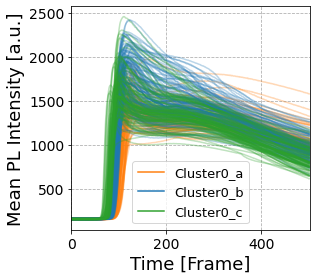

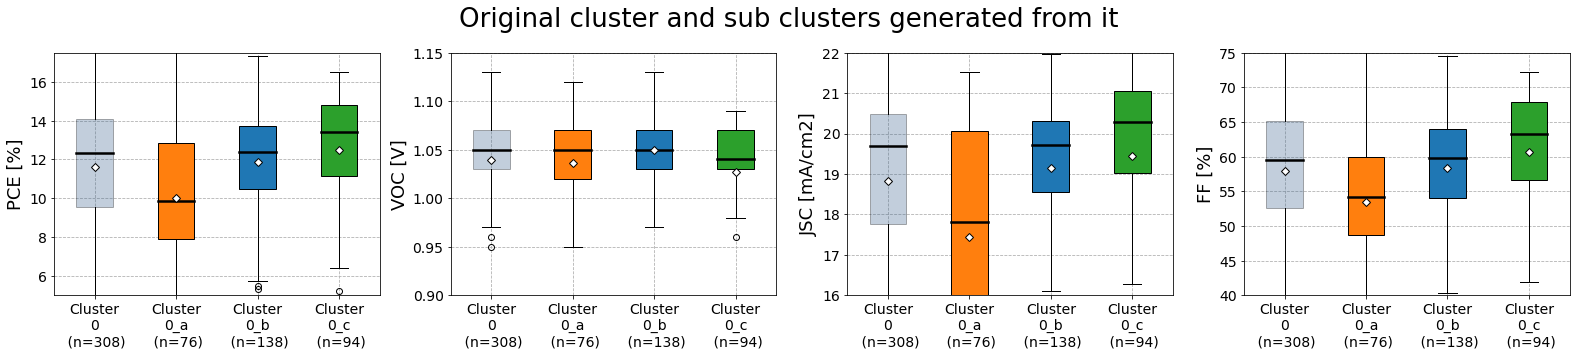

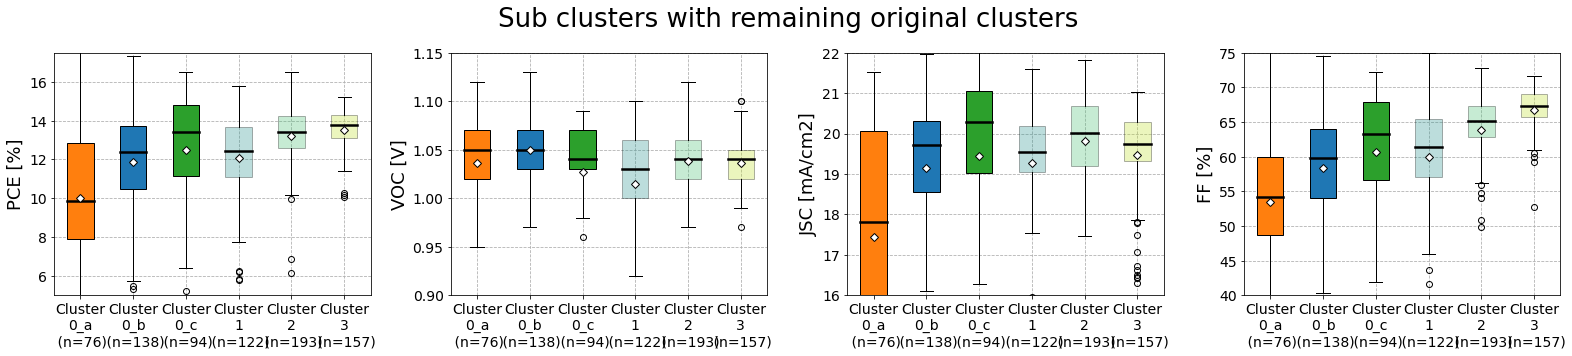

In [16]:
# plot all PL transient color-coded depending on the sub-cluster they are assigned to
fig,ax = plt.subplots(1,1, figsize=(4.5,4))
for cluster, color in zip(cluster_values_sub, color_list_sub):
    clusterDF = subClustering.xs(cluster, level=1)
    for row in range(len(clusterDF)):
        ax.plot(clusterDF.iloc[row], alpha = 0.3, color = color)
    ax.plot(clusterDF.median(), alpha = 0.99, color = color, label = cluster_valuesName[cluster])
ax.legend(fontsize = 13)
ax.set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
ax.set_ylabel("Mean PL Intensity [a.u.]", fontsize = fontSizeSetLarge)
ax.grid(which = "both", linestyle = '--')
ax.tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
plt.xlim(0,len(clusterDF.iloc[row]))
fig.tight_layout() 
plt.show()

# depending on number of sub-clusters the pv parameters of the original cluster and the sub clusters are chosen. Also the color are chosen as they have been used previously
originalColorList = [(0.206756, 0.371758, 0.553117, 1.0), (0.127568, 0.566949, 0.550556, 1.0), (0.266941, 0.748751, 0.440573, 1.0), (0.741388, 0.873449, 0.149561, 1.0)]
if k_sub == 2:
    combinedColors2 = [
     originalColorList[reclusterCluster],
     color1,color2]
    xlabels = ['Cluster\n0', 'Cluster\n0_a', 'Cluster\n0_b']
    widths = (0.5,0.5,0.5)
    ticks = [1,2,3]
    combinedList2=[[pvParamsClusters[0][reclusterCluster],pvParamsClusters_Sub[0][0],pvParamsClusters_Sub[0][1]],
     [pvParamsClusters[1][reclusterCluster],pvParamsClusters_Sub[1][0],pvParamsClusters_Sub[1][1]],
     [pvParamsClusters[2][reclusterCluster],pvParamsClusters_Sub[2][0],pvParamsClusters_Sub[2][1]],
     [pvParamsClusters[3][reclusterCluster],pvParamsClusters_Sub[3][0],pvParamsClusters_Sub[3][1]]]
elif k_sub == 3:
    combinedColors2 = [
     originalColorList[reclusterCluster],
     color1,color2,color3]
    xlabels = ['Cluster\n0', 'Cluster\n0_a', 'Cluster\n0_b', 'Cluster\n0_c']
    widths = (0.5,0.5,0.5,0.5)
    ticks = [1,2,3,4]
    combinedList2 = [[pvParamsClusters[0][reclusterCluster],pvParamsClusters_Sub[0][0],pvParamsClusters_Sub[0][1],pvParamsClusters_Sub[0][2]],
     [pvParamsClusters[1][reclusterCluster],pvParamsClusters_Sub[1][0],pvParamsClusters_Sub[1][1],pvParamsClusters_Sub[1][2]],
     [pvParamsClusters[2][reclusterCluster],pvParamsClusters_Sub[2][0],pvParamsClusters_Sub[2][1],pvParamsClusters_Sub[2][2]],
     [pvParamsClusters[3][reclusterCluster],pvParamsClusters_Sub[3][0],pvParamsClusters_Sub[3][1],pvParamsClusters_Sub[3][2]]]

# plot the performance parameters of the original cluster and the new sub-clusters in the form of box plots
fig,ax = plt.subplots(1,4, figsize = (22,5))
for ix, paramName in enumerate(["pce","voc","jsc","ff"]):
    bplot1 = ax[ix].boxplot(combinedList2[ix], medianprops = medianprops, meanprops = meanprops, meanline = False, showmeans = True,patch_artist = True) 
    cnt = 0
    for ixx,box in enumerate(bplot1['boxes']):
        #if (ixx<reclusterCluster) | (ixx>reclusterCluster+k_sub-1):
        if ixx<1:
            box.set_alpha(0.3)
        box.set(facecolor = combinedColors2[cnt] ) 
        cnt += 1
    ax[ix].set_xticks(ticks, minor = False)
    nList = []
    for ix2,color in enumerate( combinedColors2):
        nList.append("\n (n=" +str(len(combinedList2[3][ix2]))+")")
    newList = []
    for yy in range(len(xlabels)):
        newList.append(xlabels[yy]+nList[yy])
    newList
    ax[ix].set_xticklabels(newList, fontdict = None, minor = False, fontsize = fontSizeSetLarge)
    ax[ix].grid(which = "both", linestyle = '--')
    ax[ix].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
ax[0].set_ylim(pceLims)
ax[1].set_ylim(vocLims)
ax[2].set_ylim(jscLims)
ax[3].set_ylim(ffLims)
ax[0].set_ylabel("PCE [%]", fontsize = fontSizeSetLarge) 
ax[1].set_ylabel("VOC [V]", fontsize = fontSizeSetLarge) 
ax[2].set_ylabel("JSC [mA/cm2]", fontsize = fontSizeSetLarge) 
ax[3].set_ylabel("FF [%]", fontsize = fontSizeSetLarge) 
plt.suptitle("Original cluster and sub clusters generated from it", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()

# depending on number of sub-clusters the pv parameters of the remaining original clusters and the sub clusters are chosen
if k_sub == 2:
    combinedColors3 = [x for i,x in enumerate(originalColorList) if i!=reclusterCluster]
    combinedColors3[reclusterCluster:reclusterCluster] = [color1,color2]
    xlabels = ['Cluster\n0_a', 'Cluster\n0_b', 'Cluster\n1', 'Cluster\n2', 'Cluster\n3']
    ticks = [1,2,3,4,5]
elif k_sub == 3:
    combinedColors3 = [x for i,x in enumerate(originalColorList) if i!=reclusterCluster]
    combinedColors3[reclusterCluster:reclusterCluster] = [color1,color2,color3]
    xlabels = ['Cluster\n0_a', 'Cluster\n0_b', 'Cluster\n0_c', 'Cluster\n1', 'Cluster\n2', 'Cluster\n3']
    ticks = [1,2,3,4,5,6]
ls0,ls1,ls2,ls3 = [],[],[],[]
for x in range(4):
    if x != reclusterCluster:
        ls0.append(pvParamsClusters[0][x])
        ls1.append(pvParamsClusters[1][x])
        ls2.append(pvParamsClusters[2][x])
        ls3.append(pvParamsClusters[3][x])
ls0[reclusterCluster:reclusterCluster] = list(pvParamsClusters_Sub[0][:])
ls1[reclusterCluster:reclusterCluster] = list(pvParamsClusters_Sub[1][:])
ls2[reclusterCluster:reclusterCluster] = list(pvParamsClusters_Sub[2][:])
ls3[reclusterCluster:reclusterCluster] = list(pvParamsClusters_Sub[3][:])
combinedList3 = [ls0,ls1,ls2,ls3]

# plot the performance parameters of the remaining original clusters and the new sub-clusters in the form of box plots
medianprops = dict(linestyle = '-', linewidth = 2.5, color = 'k')
meanprops = dict(marker = 'D', markeredgecolor = 'black',markerfacecolor = 'white')
fig,ax = plt.subplots(1,4, figsize = (22,5))
for ix, paramName in enumerate(["pce","voc","jsc","ff"]):
    bplot1 = ax[ix].boxplot(combinedList3[ix], medianprops = medianprops, meanprops = meanprops, meanline = False, showmeans = True,patch_artist = True) 
    cnt = 0
    for ixx,box in enumerate(bplot1['boxes']):
        if (ixx<reclusterCluster) | (ixx>reclusterCluster+k_sub-1):
            box.set_alpha(0.3)
        box.set(facecolor = combinedColors3[cnt] ) 
        cnt += 1
    ax[ix].set_xticks(ticks, minor = False)
    nList = []
    for ix2,color in enumerate(combinedColors3):
        nList.append("\n (n=" +str(len(combinedList3[3][ix2]))+")")
    newList = []
    for yy in range(len(xlabels)):
        newList.append(xlabels[yy]+nList[yy])
    newList
    ax[ix].set_xticklabels(newList, fontdict = None, minor = False, fontsize = fontSizeSetLarge)
    ax[ix].grid(which = "both", linestyle = '--')
    ax[ix].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
ax[0].set_ylim(pceLims)
ax[1].set_ylim(vocLims)
ax[2].set_ylim(jscLims)
ax[3].set_ylim(ffLims)
ax[0].set_ylabel("PCE [%]", fontsize = fontSizeSetLarge) 
ax[1].set_ylabel("VOC [V]", fontsize = fontSizeSetLarge) 
ax[2].set_ylabel("JSC [mA/cm2]", fontsize = fontSizeSetLarge) 
ax[3].set_ylabel("FF [%]", fontsize = fontSizeSetLarge) 
plt.suptitle("Sub clusters with remaining original clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()

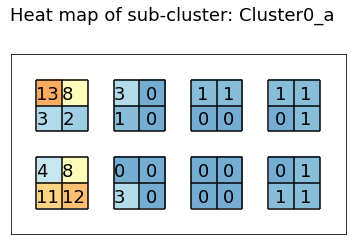

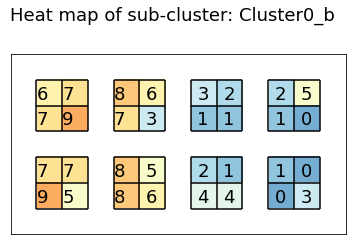

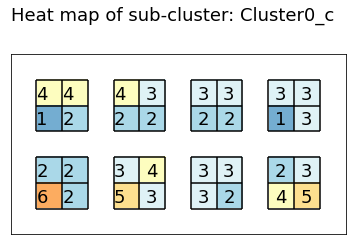

In [17]:
# iterate through all sub-clusters and plot a map showing at which substrate locations the PL signals assigned to the sub-cluster were detected
for clustNo in clusters_sub:
     
    # in current sub-cluster get number of cells located at each patchID (pacthID encodes the location of each solar cell on the large substrate)
    locID = {
          11: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==11]),
          12: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==12]),
          13: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==13]),
          14: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==14]),
          21: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==21]),
          22: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==22]),
          23: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==23]),
          24: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==24]),
          31: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==31]),
          32: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==32]),
          33: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==33]),
          34: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==34]),
          41: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==41]),
          42: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==42]),
          43: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==43]),
          44: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==44]),
          51: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==51]),
          52: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==52]),
          53: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==53]),
          54: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==54]),
          61: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==61]),
          62: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==62]),
          63: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==63]),
          64: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==64]),
          71: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==71]),
          72: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==72]),
          73: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==73]),
          74: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==74]),
          81: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==81]),
          82: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==82]),
          83: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==83]),
          84: len(db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]][db.iloc[tempDB.index[subClustering.xs(clustNo, level=1).index]]["patchID"]==84])
        }

    # arrange the solar cells assigned to the different patchIDs to the phyical location on the large substrat
    physicalLocations = np.zeros((4,8))
    physicalLocations[3,6] = locID[11]
    physicalLocations[2,6] = locID[12]
    physicalLocations[3,7] = locID[13]
    physicalLocations[2,7] = locID[14]
    physicalLocations[1,6] = locID[21]
    physicalLocations[0,6] = locID[22]
    physicalLocations[1,7] = locID[23]
    physicalLocations[0,7] = locID[24]
    physicalLocations[3,4] = locID[31]
    physicalLocations[2,4] = locID[32]
    physicalLocations[3,5] = locID[33]
    physicalLocations[2,5] = locID[34]
    physicalLocations[1,4] = locID[41]
    physicalLocations[0,4] = locID[42]
    physicalLocations[1,5] = locID[43]
    physicalLocations[0,5] = locID[44]
    physicalLocations[3,2] = locID[51]
    physicalLocations[2,2] = locID[52]
    physicalLocations[3,3] = locID[53]
    physicalLocations[2,3] = locID[54]
    physicalLocations[1,2] = locID[61]
    physicalLocations[0,2] = locID[62]
    physicalLocations[1,3] = locID[63]
    physicalLocations[0,3] = locID[64]
    physicalLocations[3,0] = locID[71]
    physicalLocations[2,0] = locID[72]
    physicalLocations[3,1] = locID[73]
    physicalLocations[2,1] = locID[74]
    physicalLocations[1,0] = locID[81]
    physicalLocations[0,0] = locID[82]
    physicalLocations[1,1] = locID[83]
    physicalLocations[0,1] = locID[84]

    # space the physical locations out on the area of the entire substrate
    substrate = np.empty((7,13))
    substrate[:,:] = np.NaN
    substrate[1:3,1:3] = physicalLocations[0:2,0:2]
    substrate[4:6,1:3] = physicalLocations[2:4,0:2]
    substrate[1:3,4:6] = physicalLocations[0:2,2:4]
    substrate[4:6,4:6] = physicalLocations[2:4,2:4]
    substrate[1:3,7:9] = physicalLocations[0:2,4:6]
    substrate[4:6,7:9] = physicalLocations[2:4,4:6]
    substrate[1:3,10:12] = physicalLocations[0:2,6:8]
    substrate[4:6,10:12] = physicalLocations[2:4,6:8]

    fig,ax_3 = plt.subplots()
    subsLoc = ax_3.imshow(substrate, cmap = colors.LinearSegmentedColormap.from_list("",plt.get_cmap('RdYlBu')(np.linspace(0.8, 0.3))))
    
    # write number of cells in each location
    vertical_Coordinates = [1.25,2.25,4.25,5.25]
    horizontal_Coordinates = [0.5,1.5,3.5,4.75,6.75,7.75,9.75,10.75]
    for x in range(len(physicalLocations)):
        for y in range(len(physicalLocations[0])):
            xX = vertical_Coordinates[x]
            yY = horizontal_Coordinates[y]
            ax_3.text(yY,xX,str(int(physicalLocations[x,y])), fontsize = 18)

    # draw black lines as borders of the active areas
    vert_lines = [0.5,2.5,3.5,5.5,1.5,4.5]
    hori_lines = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
    for a in range(len(vert_lines)): 
        ax_3.hlines(vert_lines[a],colors = "k", xmin = 0.5, xmax = 2.5)
        ax_3.hlines(vert_lines[a],colors = "k", xmin = 3.5, xmax = 5.5)
        ax_3.hlines(vert_lines[a],colors = "k", xmin = 6.5, xmax = 8.5)
        ax_3.hlines(vert_lines[a],colors = "k", xmin = 9.5, xmax = 11.5)
    for a in range(len(hori_lines)): 
        ax_3.vlines(hori_lines[a],colors = "k", ymin = 0.5, ymax = 2.5)
        ax_3.vlines(hori_lines[a],colors = "k", ymin = 3.5, ymax = 5.5)

    subsLoc.set_clim([int(np.min(physicalLocations)), int(np.max(physicalLocations))])
    ax_3.set_xticks([])
    ax_3.set_xticks([], minor = True)
    ax_3.set_yticks([])
    ax_3.set_yticks([], minor = True)
    plt.suptitle("Heat map of sub-cluster: "+str(cluster_valuesName[clustNo]), fontsize = fontSizeSetLarge)
    plt.show()